# A Classical Machine Learning Problem: Predicting Customer Churn

```{index} Customer churn
```

Customer churn, where customers stop using a company's services, is a major concern for businesses as it directly impacts revenue. Traditionally, companies tackled this issue by manually analyzing past data and relying on the intuition of marketing and sales teams. They used methods like customer surveys, simple statistical analysis, and basic segmentation based on purchase history and customer interactions. These approaches provided some insights but were often reactive and lacked precision.

With the advent of machine learning, predicting and managing customer churn has become more efficient and accurate. Machine learning models can analyze vast amounts of data to identify patterns and predict which customers are likely to leave. These models consider various factors such as customer behavior, transaction history, and engagement metrics, providing a comprehensive analysis that traditional methods cannot match.

Machine learning enables real-time data processing, allowing businesses to react swiftly to at-risk customers. It also allows for personalized retention strategies, as models can segment customers into detailed groups and suggest specific actions for each group. Moreover, machine learning models continuously improve by learning from new data, ensuring they stay relevant as customer behaviors and market conditions change.

In this experiment, we will explore a small dataset which includes customer information and churn status. We will build a machine learning model to predict customer churn and evaluate its performance. By the end of this experiment, you will have a better understanding of how machine learning addresses this kind of business problem and how to apply it to real-world scenarios.

We will use a [bank customer churn dataset](https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn) from Kaggle, which contains information about bank customers and whether they churned or not.

## The dataset

Let's start by loading the dataset and examining its features.

In [1]:
# Download dataset

!kaggle datasets download -d radheshyamkollipara/bank-customer-churn -p .data/ --unzip

# Load dataset
import pandas as pd

churn = pd.read_csv('.data/Customer-Churn-Records.csv')
print("Train:", churn.shape)

Dataset URL: https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn
License(s): other
100%|█████████████████████████████████████████| 307k/307k [00:00<00:00, 844kB/s]
100%|█████████████████████████████████████████| 307k/307k [00:00<00:00, 840kB/s]
Train: (10000, 18)


We have $\mathbf{10000}$ rows, and $\mathbf{14}$ columns, not particularly large, but enough to build a simple model. Let's look at the available columns.

In [2]:
churn

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0,0,1,DIAMOND,300
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,0,5,PLATINUM,771
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1,1,3,SILVER,564
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,1,2,GOLD,339


We have a mix of categorical and numerical features, some will clearly be of no use for our model (`CustomerId`, `Surname`, `RowNumber`), so let us perform a little bit of cleansing. We will drop any rows with missing values and remove the columns mentioned above.

In [3]:

# Remove missing values, if any
churn = churn.dropna()
churn.shape

(10000, 18)

In [4]:
# Remove whitespaces from column names
churn.columns = churn.columns.str.strip()

# Drop CustomerID, RowNumber and Surname columns
churn = churn.drop(columns=['CustomerId', 'RowNumber', 'Surname'])

That's better. Let's look at the data types of the various columns.

In [5]:
churn.dtypes

CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Complain                int64
Satisfaction Score      int64
Card Type              object
Point Earned            int64
dtype: object

We have a mix of numerical and categorical columns, and some of the numerica columns are just truth values - we will convert them to booleans. We will also convert the categorical columns to one-hot encoded columns.

In [6]:
import pandas as pd

# Convert binary features to booleans, 1 as True, 0 as False
churn['Exited'] = churn['Exited'].astype(bool)
churn['Complain'] = churn['Complain'].astype(bool)
churn['HasCrCard'] = churn['HasCrCard'].astype(bool)
churn['IsActiveMember'] = churn['IsActiveMember'].astype(bool)

# One-hot encode categorical features
churn_encoded = pd.get_dummies(churn, drop_first=True)

```{index} One-hot encoding
```

```{admonition} One-hot vs label encoding
:class: tip
One-hot encoding and label encoding are two common techniques for converting categorical data into a numerical format that machine learning algorithms can process. One-hot encoding is used when the categorical variables are nominal, meaning there is no inherent order among the categories. This technique creates a new binary column for each category, with a 1 indicating the presence of the category and a 0 indicating its absence. This approach ensures that the model does not assume any ordinal relationship between the categories, making it suitable for algorithms that are sensitive to numerical relationships, such as linear regression and K-nearest neighbors.

On the other hand, label encoding assigns a unique integer to each category, which is more suitable for ordinal categorical variables where the categories have a meaningful order. This method is straightforward and efficient in terms of memory and computational resources, especially when dealing with a large number of categories. However, it may introduce an artificial ordinal relationship if used on nominal variables, potentially misleading the model.

While one-hot encoding can lead to high-dimensional data, especially with many categories, it prevents the introduction of unintended ordinal relationships. Label encoding, being more compact, works well with tree-based algorithms like decision trees and random forests that can handle numerical encodings without assuming any specific order. The choice between the two methods depends on the nature of the categorical data and the requirements of the machine learning algorithm used. One-hot encoding is preferred for non-ordinal data and algorithms sensitive to numerical relationships, while label encoding is ideal for ordinal data and tree-based algorithms.
```

Let's look at what the data looks like now.

In [7]:
churn_encoded

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned,Geography_Germany,Geography_Spain,Gender_Male,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER
0,619,42,2,0.00,1,True,True,101348.88,True,True,2,464,False,False,False,False,False,False
1,608,41,1,83807.86,1,False,True,112542.58,False,True,3,456,False,True,False,False,False,False
2,502,42,8,159660.80,3,True,False,113931.57,True,True,3,377,False,False,False,False,False,False
3,699,39,1,0.00,2,False,False,93826.63,False,False,5,350,False,False,False,True,False,False
4,850,43,2,125510.82,1,True,True,79084.10,False,False,5,425,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,True,False,96270.64,False,False,1,300,False,False,True,False,False,False
9996,516,35,10,57369.61,1,True,True,101699.77,False,False,5,771,False,False,True,False,True,False
9997,709,36,7,0.00,1,False,True,42085.58,True,True,3,564,False,False,False,False,False,True
9998,772,42,3,75075.31,2,True,False,92888.52,True,True,2,339,True,False,True,True,False,False


That's much better, we have all the columns in the best possible shape for a model, and we are ready to continue. Note the hot-encoded columns, which have been added to the dataset, such as `Gender_Male` and `Geography_Germany`.

## Understanding the data better

It is always a good idea to grasp the data better before diving into building a model. One important first step is understanding the distribution types of the features, as this can help in selecting the appropriate machine learning algorithms and preprocessing techniques, especially for numerical features whose scales may vary significantly.

We will star by looking at the distribution of the numerical features, let us plot histograms for all the numerical columns, together with QQ plots to check for normality.

```{index} QQ plot
```

```{admonition} QQ plot
:class: tip
A QQ plot, or quantile-quantile plot, is a graphical tool used to compare two probability distributions by plotting their quantiles against each other. It helps to determine if the distributions are similar by showing how well the points follow a straight line. If the points lie approximately along a 45-degree line, it indicates that the distributions being compared are similar. QQ plots are commonly used to check the normality of a dataset by comparing the sample distribution to a theoretical normal distribution. Deviations from the straight line can indicate departures from normality or highlight differences between the two distributions. This tool is particularly useful in statistical analysis for assessing assumptions and identifying anomalies.
```

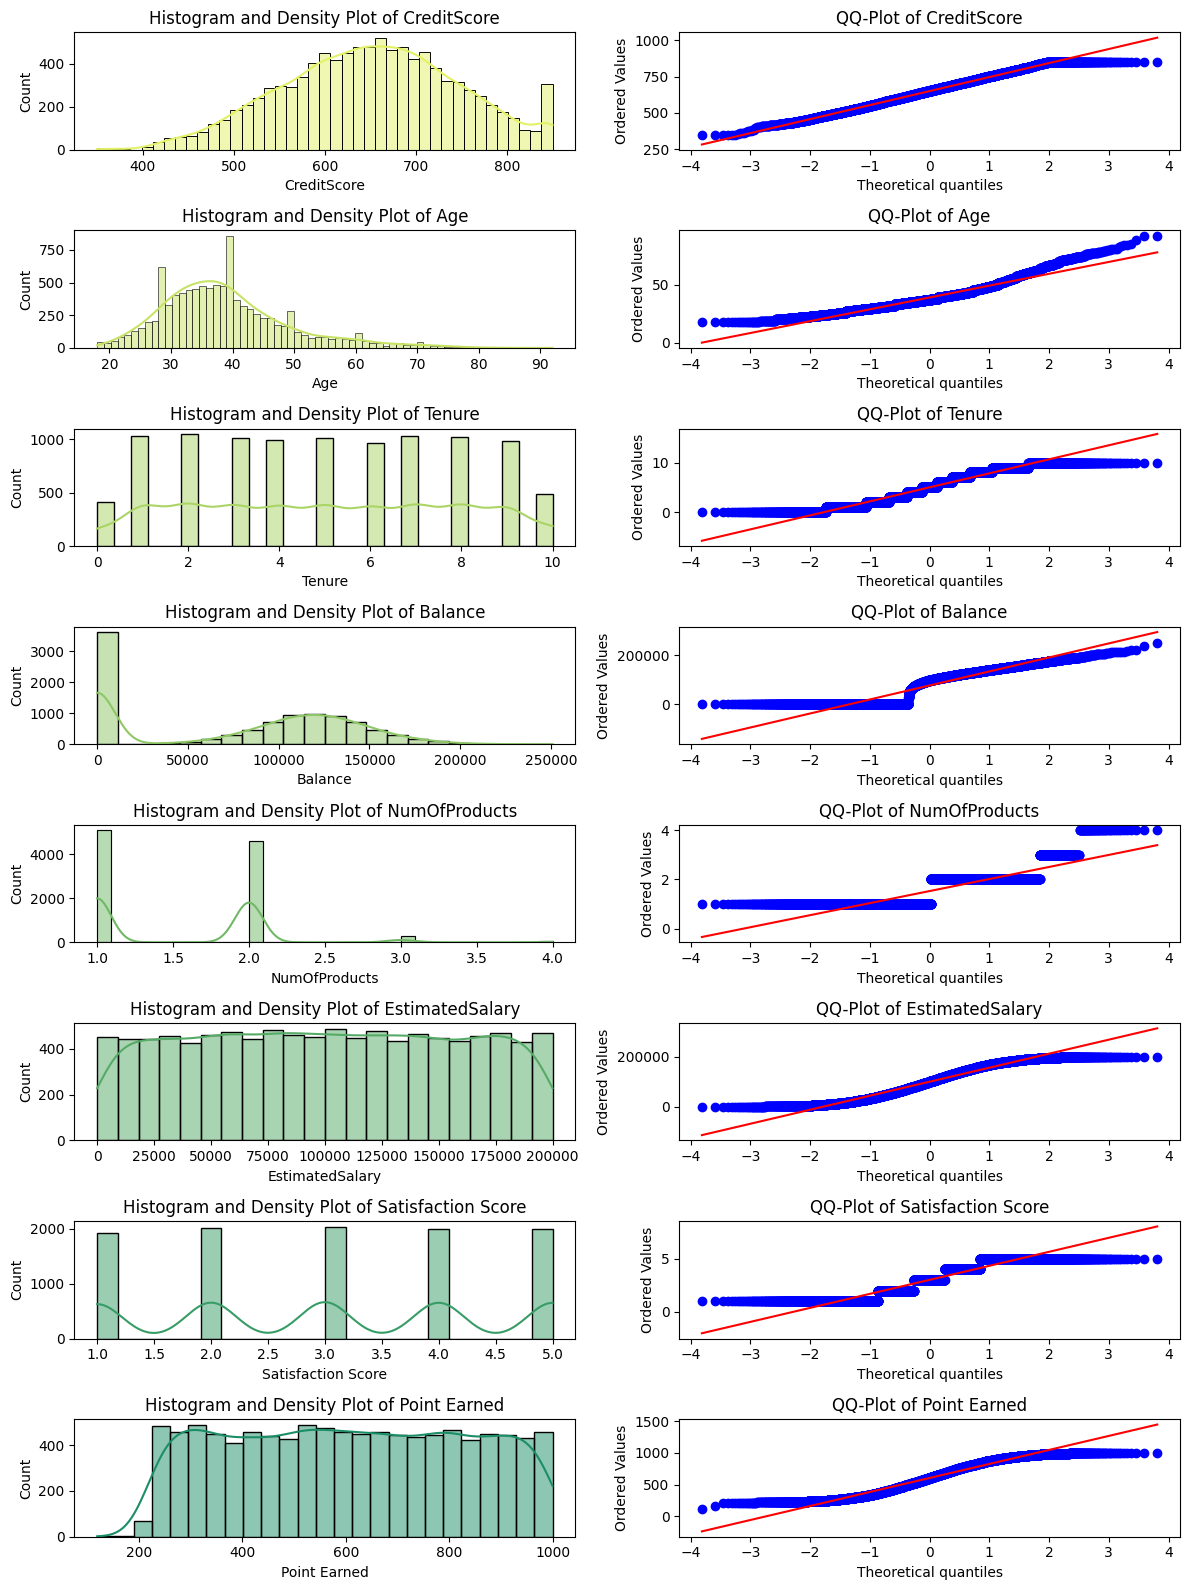

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd

def plot_distributions_grid(data):
    # Select numeric columns
    numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
    num_cols = len(numeric_cols)

    # Calculate grid size
    grid_rows = num_cols
    grid_cols = 2  # one for histogram, one for QQ-plot

    # Create subplots
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(12, 2 * num_cols))
    
    # Generate colors from the summer_r palette
    palette = sns.color_palette('summer_r', num_cols)

    for idx, column in enumerate(numeric_cols):
        # Plot histogram and density plot
        sns.histplot(data[column], kde=True, ax=axes[idx, 0], color=palette[idx % len(palette)])
        axes[idx, 0].set_title(f'Histogram and Density Plot of {column}')
        
        # Plot QQ-plot
        stats.probplot(data[column], dist="norm", plot=axes[idx, 1])
        axes[idx, 1].set_title(f'QQ-Plot of {column}')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_distributions_grid(churn_encoded)


From the histograms and QQ plots, we can see that most of the numerical features are not normally distributed. This is important to note, as some machine learning algorithms assume this is the case. In such cases, we may need to apply transformations to make the data more normally distributed or use algorithms that are robust to non-normal data.

We can tall from above that:

- `CreditScore` is normally distributed, with some outliers;
- `Age` is not normally distributed, with a left skew;
- `Tenure` is a uniform distribution with descrete values;
- `Balance` is roughly normally distributed, with a large number of near-zero values;
- `NumOfProducts` is discrete and multimodal;
- `EstimatedSalary` is uniform;
- `SatisfactionScore` is discrete and multimodal;
- `Point Earned` is uniform with some skewness and lower end outliers.

We will take these distribution considerations later when we define scaling and transformation strategies for the numerical features.

Let's Now look at the distribution of the target variable, `Exited`, which indicates whether a customer churned or not, and the interdependencies between some of the features. A useful tool for this is a pair plot, which shows the relationships between pairs of features and how they correlate with the target variable.

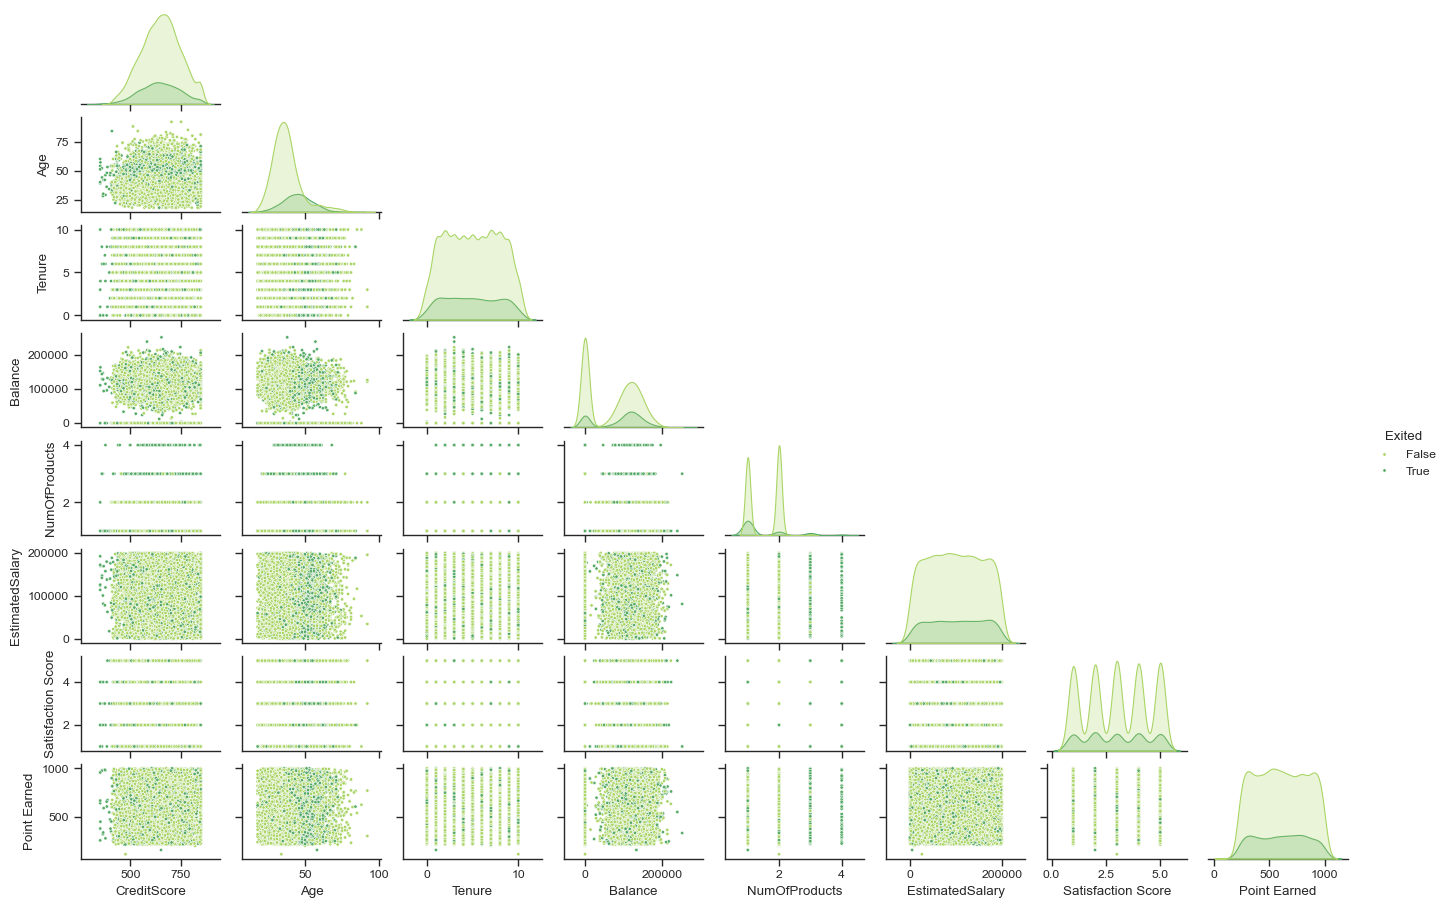

In [9]:

# Pairplot of the dataset for non-categorical features, with Exited as the target (stick to a sample for performance)
import seaborn as sns
import matplotlib.pyplot as plt

# Select non-categorical colums only
non_categorical_columns = churn_encoded.select_dtypes(exclude='bool').columns

# Plot the pairplot for the non-categorical columns only
sns.set_theme(context="paper", style="ticks")  # Set the style of the visualization
pairplot = sns.pairplot(
    churn,
    vars=non_categorical_columns,
    hue="Exited",
    palette="summer_r",
    corner=True,
    height=1.15,
    aspect=1.5,
    markers=[".", "."])
plt.show()

THe pair plot shows a few interesting patterns:

- There is a pattern between `Age` and `Exited`, with a band of churned customers in the middle age range;
- Customers with a larger number of products are more likely to churn;
- Counterintuitively, there is no clear relationship between customer satisfaction and churn.

Let us also look at the correlation matrix of the numerical features to see if there are any strong correlations between them.

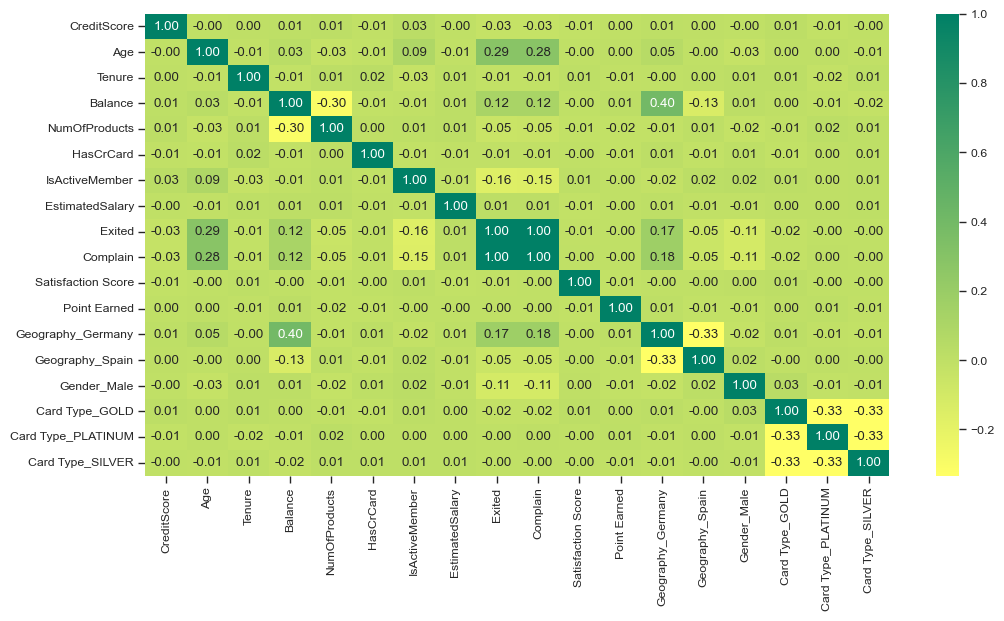

In [10]:
# Plot a correlation heatmap
plt.figure(figsize=(12, 6))
correlation = churn_encoded.corr()
heatmap = sns.heatmap(correlation, annot=True, cmap="summer_r", fmt=".2f")
plt.show()

Notice that `Exited` and `Complain` correlate perfectly ($\mathbf(1.0)$), suggesting that both are potentially measuring the same thing. We will remove `Complain` from the dataset, as it will not be a useful feature for our model.

```{index} Perfect correlation
```

```{admonition} Perfect correlation
:class: tip
Perfectly correlated features are those that have a direct and proportional relationship with each other. When one feature is the target variable and it is perfectly correlated with another feature, this implies that there is an exact linear relationship between them. In other words, the value of the target variable can be precisely predicted using the other feature without any error.

This situation typically suggests redundancy in the dataset because one feature contains all the information necessary to predict the other. If the feature that is perfectly correlated with the target variable is included in the model, it might lead to several implications.

Firstly, the model's interpretability could be compromised. A perfectly correlated feature does not provide any additional insight because it simply replicates the information already present in the target variable. This redundancy can lead to an overestimation of the model's predictive power during training since the model is essentially learning the direct relationship rather than discovering any underlying patterns.

Moreover, in practical scenarios, perfect correlation is often a sign of data leakage. Data leakage occurs when information from outside the training dataset is used to create the model, which can result in overly optimistic performance estimates and poor generalization to new data. It typically indicates that the feature used as a predictor might not be available or might not have the same predictive power in real-world applications.

For instance, if the target variable is a financial outcome like customer churn, and another feature is perfectly correlated with it, this might suggest that the feature contains post-event information that wouldn't be available at the time of prediction. Including such features can lead to models that are highly accurate on historical data but fail in real-world deployment.

Additionally, perfect correlation can inflate the variance of the estimated coefficients in linear models, leading to issues with multicollinearity. This can make the model's estimates highly sensitive to changes in the input data and can cause instability in the model's predictions.

To address this, one should consider removing or combining the perfectly correlated feature with the target variable. This helps in ensuring that the model is not relying on redundant or potentially leaked information, thereby improving the model's robustness and generalizability. It also encourages the model to learn from more subtle, underlying patterns in the data rather than from straightforward, but unrealistic, relationships.
```

In [11]:
# Drop the Complain feature
churn_encoded = churn_encoded.drop(columns=['Complain'])

Let us now visualise the dataset using dimensionality reduction techniques, to see if we can identify any patterns in the data, and to assess the separability of the classes.

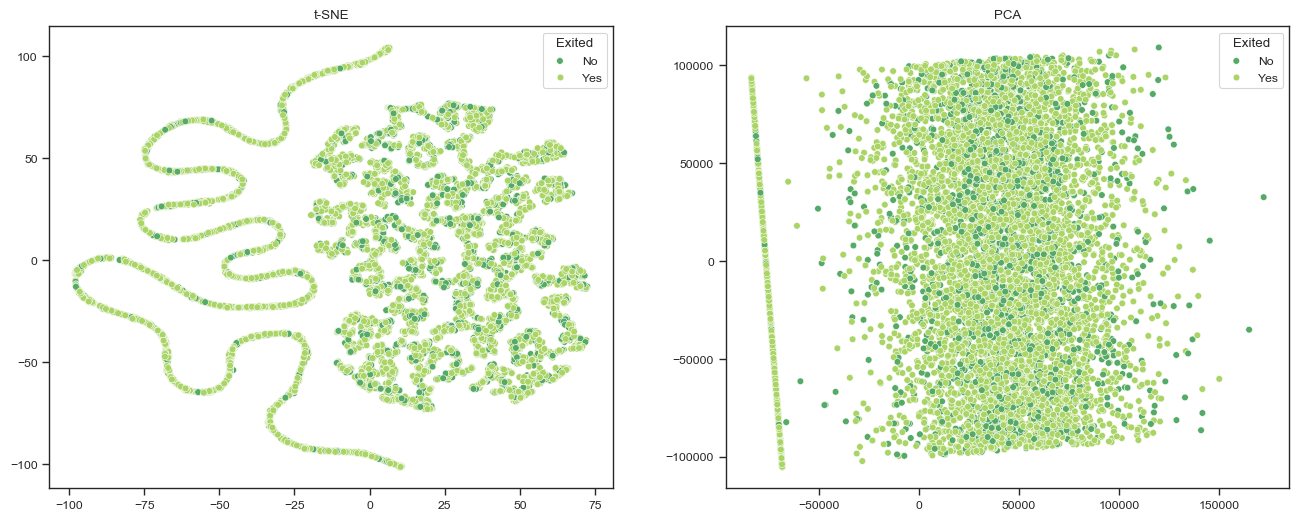

In [12]:

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Fit and transform t-SNE
tsne = TSNE(n_components=2, random_state=42)
churn_tsne = tsne.fit_transform(churn_encoded.drop(columns=['Exited']))

# Fit and transform PCA
pca = PCA(n_components=2, random_state=42)
churn_pca = pca.fit_transform(churn_encoded.drop(columns=['Exited']))

hue_order = churn_encoded['Exited'].unique()

# Plot t-SNE and PCA side by side
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot t-SNE
tsne_plot = sns.scatterplot(
    x=churn_tsne[:, 0],
    y=churn_tsne[:, 1],
    hue=churn_encoded['Exited'],
    palette="summer_r",
    ax=ax[0])
tsne_plot.set_title("t-SNE")
tsne_plot.legend(title='Exited', loc='upper right', labels=['No', 'Yes'])

# Plot PCA
pca_plot = sns.scatterplot(
    x=churn_pca[:, 0],
    y=churn_pca[:, 1],
    hue=churn_encoded['Exited'],
    palette="summer_r",
    ax=ax[1])
pca_plot.set_title("PCA")
pca_plot.legend(title='Exited', loc='upper right', labels=['No', 'Yes'])

plt.show()

The t-SNE plot showcases some interesting patterns, such as the elongated, snake-like shape observed on the left side. These intricate patterns suggest the presence of non-linear relationships within the data, which are effectively captured by the t-SNE algorithm. This non-linear nature of the data indicates that the relationships between features and the target variable might not be straightforward, necessitating models that can handle complex interactions.

## Balancing the dataset and creating a holdout set

Before we proceed with building a model, let us try to address any class imbalance in the dataset. Class imbalance occurs when one class significantly outnumbers the other, leading to biased model predictions. In our case, the number of customers who churned (`Exited=1`) is much smaller than those who did not churn (`Exited=0`). We will also create a holdout set to evaluate the model's performance on unseen data.

In [13]:
# Count the number of churned and non-churned samples
print(churn_encoded['Exited'].value_counts())

Exited
False    7962
True     2038
Name: count, dtype: int64


Only about 20% of the dataset contains churned customers, which is a significant class imbalance. We will address this by oversampling the minority class using the Synthetic Minority Over-sampling Technique (SMOTE). SMOTE generates synthetic samples by interpolating between existing samples of the minority class, thereby balancing the class distribution.

```{index} Imbalanced data ; Limits of SMOTE
```

```{admonition} Limitations of SMOTE
:class: tip
SMOTE has several limitations. One significant issue is overfitting, particularly in small datasets. By generating synthetic examples, SMOTE can produce duplicates or near-duplicates that don't add new information, leading to the model learning noise instead of useful patterns.

Additionally, SMOTE does not differentiate between noisy and informative data points. Consequently, if the minority class contains noise, SMOTE may generate synthetic instances based on this noise, which can degrade the model's performance. Another challenge is class separation; SMOTE can create synthetic examples that fall into the majority class space, causing overlapping regions that confuse the classifier and reduce its ability to distinguish between classes.

In high-dimensional spaces, the synthetic examples generated by SMOTE might be less effective because distance metrics become less meaningful, a phenomenon known as the "curse of dimensionality." This makes it harder to create realistic synthetic samples. Moreover, generating synthetic samples and training models on larger datasets can increase computational cost and time, which can be a significant drawback for very large datasets.

SMOTE also does not consider the importance of different features when generating new instances, potentially creating less realistic samples if some features are more important than others. Lastly, while SMOTE addresses overall class imbalance, it does not tackle any imbalance within the minority class itself. If there are sub-classes within the minority class with their own imbalances, SMOTE won't address this issue.
```

In [14]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Reserve 10% of the samples as a holdout set
X, X_holdout, y, y_holdout = train_test_split(
    churn_encoded.drop(columns=['Exited']),
    churn_encoded['Exited'],
    stratify=churn_encoded['Exited'],
    test_size=0.2,
    random_state=42)

# Rebalance the dataset with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Count the number of churned and non-churned samples after SMOTE
print(X_holdout.shape)
print(y_holdout.shape)
print(X_resampled.shape)
print(y_resampled.shape)
print(y_resampled.value_counts())

(2000, 16)
(2000,)
(12740, 16)
(12740,)
Exited
False    6370
True     6370
Name: count, dtype: int64


We now have a separate holdout set composed of 2000 random samples, and a balanced training set with an equal number of churned and non-churned customers. We are ready to evaluate different models to predict customer churn.

## Model selection and evaluation

Now that we have a balanced dataset, and a holdout set, let us further split the resampled dataset into training and test sets.

In [15]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
#X = churn_encoded.drop(columns=['Exited'])
#y = churn_encoded['Exited']

# Split the data into balanced train and test sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Print the shapes of the resulting datasets
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

# Verify the proportions of the 'Churn' column in the train and test sets
print("Train set 'Exited' value counts:")
print(y_train.value_counts(normalize=False))
print("Test set 'Exited' value counts:")
print(y_test.value_counts(normalize=False))

X_train: (8918, 16) y_train: (8918,)
X_test: (3822, 16) y_test: (3822,)
Train set 'Exited' value counts:
Exited
True     4496
False    4422
Name: count, dtype: int64
Test set 'Exited' value counts:
Exited
False    1948
True     1874
Name: count, dtype: int64


### Model selection

We will perform a grid search over a few different models to find the best hyperparameters for each model. We will evaluate the models using cross-validation on the training set, and later test the best models against the holdout set. Note how we are selecting different scaling strategies for the numerical features based on their distributions from our earlier analysis. 

In [16]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Define a function to apply different scalers to different features
def get_column_transformer(feature_scaler_mapping, default_scaler, all_features):
    transformers = []
    specific_features = feature_scaler_mapping.keys()
    for feature, scaler in feature_scaler_mapping.items():
        transformers.append((f"{scaler.__class__.__name__}_{feature}", scaler, [feature]))
    
    # Apply default scaler to all other features
    remaining_features = [feature for feature in all_features if feature not in specific_features]
    if remaining_features:
        transformers.append(('default_scaler', default_scaler, remaining_features))
    
    return ColumnTransformer(transformers)

# Define a function to create pipelines and perform Grid Search
def create_and_fit_model(model, param_grid, X_train, y_train, feature_scaler_mapping, default_scaler, all_features, cv=3):
    column_transformer = get_column_transformer(feature_scaler_mapping, default_scaler, all_features)
    
    pipeline = Pipeline([
        ('scaler', column_transformer),
        ('model', model)
    ])
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv)
    grid_search.fit(X_train, y_train)
    
    return grid_search

# Define the feature to scaler mapping
feature_scaler_mapping = {
    'CreditScore': StandardScaler(),
    'Age': RobustScaler(),
    'Tenure': MinMaxScaler(),
    'Balance': RobustScaler(),
    'NumOfProducts': MinMaxScaler(),
    'EstimatedSalary': MinMaxScaler(),
    'Satisfaction Score': MinMaxScaler(),
    'Point Earned': RobustScaler(),
}

# Define all features present in the dataset
all_features = X_train.columns

# Define the default scaler to be used for other features
default_scaler = RobustScaler()

# Define the models and their respective hyperparameters
models_and_params = [
    (RandomForestClassifier(random_state=42), {
        'model__n_estimators': [50, 100, 200, 300],
        'model__max_depth': [10, 15, 20, 25]
    }),
    (LogisticRegression(random_state=42), {
        'model__C': [0.1, 1, 10]
    }),
    (GradientBoostingClassifier(random_state=42), {
        'model__n_estimators': [50, 100, 200, 300],
        'model__max_depth': [5, 7, 11, 13]
    }),
    (SVC(random_state=42, probability=True), {
        'model__C': [0.1, 1, 10],
        'model__gamma': ['scale', 'auto'],
        'model__kernel': ['linear', 'rbf', 'poly']
    }),
    (KNeighborsClassifier(), {
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance']
    }),
    (GaussianNB(), {}),
    (XGBClassifier(random_state=42), {
        'model__n_estimators': [50, 100, 200, 300],
        'model__max_depth': [3, 5, 7, 9],
        'model__learning_rate': [0.01, 0.1, 0.2]
    }),
    (AdaBoostClassifier(algorithm='SAMME', random_state=42), {
        'model__n_estimators': [50, 100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 1]
    })
]

# Perform Grid Search for each model
grid_results = []
for model, param_grid in models_and_params:
    grid_search = create_and_fit_model(model, param_grid, X_train, y_train, feature_scaler_mapping, default_scaler, all_features)
    grid_results.append(grid_search)

# Extract the fitted models
rf_grid, lr_grid, gb_grid, svc_grid, knn_grid, nb_grid, xgb_grid, ada_grid = grid_results

We have done a grid search over a few different models, let us see the results of the evaluation:

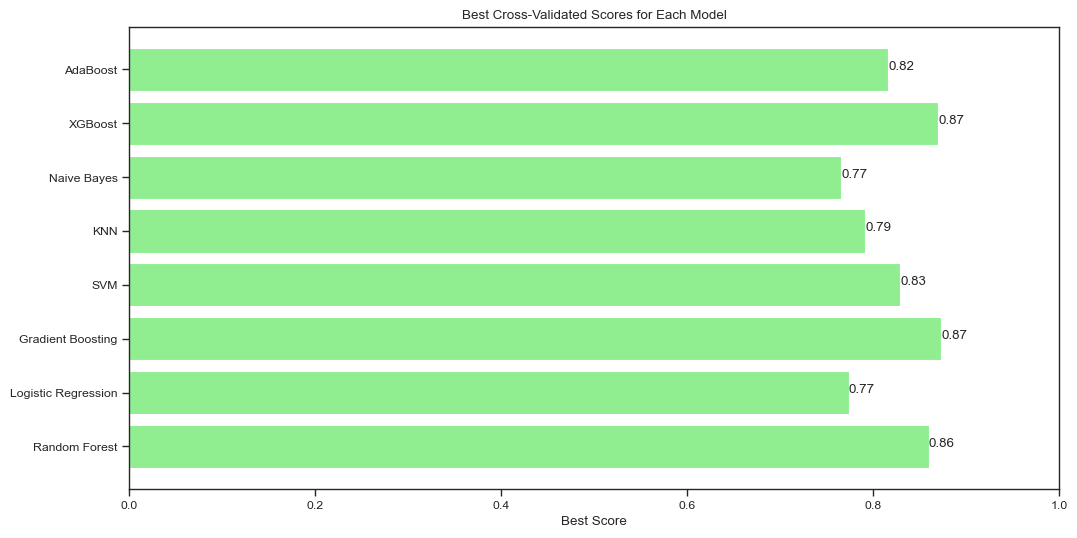

In [17]:
import matplotlib.pyplot as plt

# Model names
model_names = [
    "Random Forest",
    "Logistic Regression",
    "Gradient Boosting",
    "SVM",
    "KNN",
    "Naive Bayes",
    "XGBoost",
    "AdaBoost"
]

# Best scores
best_scores = [
    rf_grid.best_score_,
    lr_grid.best_score_,
    gb_grid.best_score_,
    svc_grid.best_score_,
    knn_grid.best_score_,
    nb_grid.best_score_,
    xgb_grid.best_score_,
    ada_grid.best_score_,
]

# Plotting best scores
plt.figure(figsize=(12, 6))
plt.barh(model_names, best_scores, color='lightgreen')
plt.xlabel('Best Score')
plt.title('Best Cross-Validated Scores for Each Model')
plt.xlim(0, 1)
for index, value in enumerate(best_scores):
    plt.text(value, index, f'{value:.2f}')
plt.show()

Keep in mind that these results are based on the training set and cross-validation, and may not generalize to the holdout set. It is clear that three models stand out: Random Forest, Gradient Boosting, and XGBoost.

Later we will evaluate these models on the holdout set to get a more accurate estimate of their performance, first let us look at the hyper-parameter values for the best models.

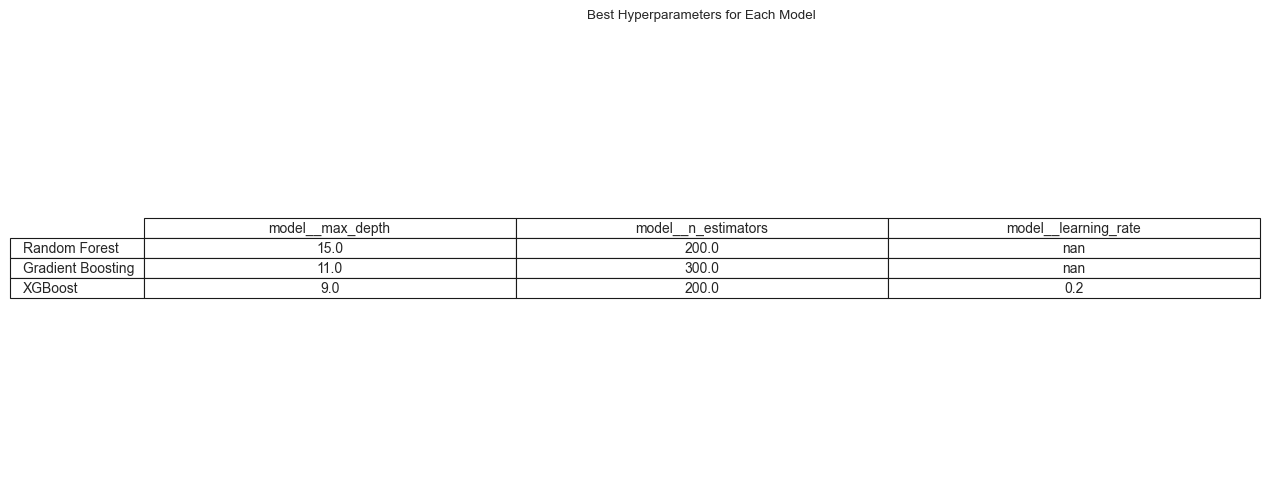

In [18]:
import pandas as pd

# Model names (ensure this list matches the one used in the bar plot)
model_names = [
    "Random Forest",
    "Gradient Boosting",
    "XGBoost",
]

# Collecting best parameters
best_params = [
    rf_grid.best_params_,
    gb_grid.best_params_,
    xgb_grid.best_params_
]

# Converting to a DataFrame for better visualization
params_df = pd.DataFrame(best_params, index=model_names)

# Plotting the best parameters for each model
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')
tbl = ax.table(cellText=params_df.values, colLabels=params_df.columns, rowLabels=params_df.index, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)
plt.title('Best Hyperparameters for Each Model')
plt.show()

### Understanding the most important features

Feature importance is a critical aspect of model interpretation, as it helps identify the key factors driving the predictions. By analyzing the importance of each feature, we can gain insights into the underlying relationships between the input variables and the target variable. This information is valuable for understanding the model's decision-making process and identifying areas for improvement.

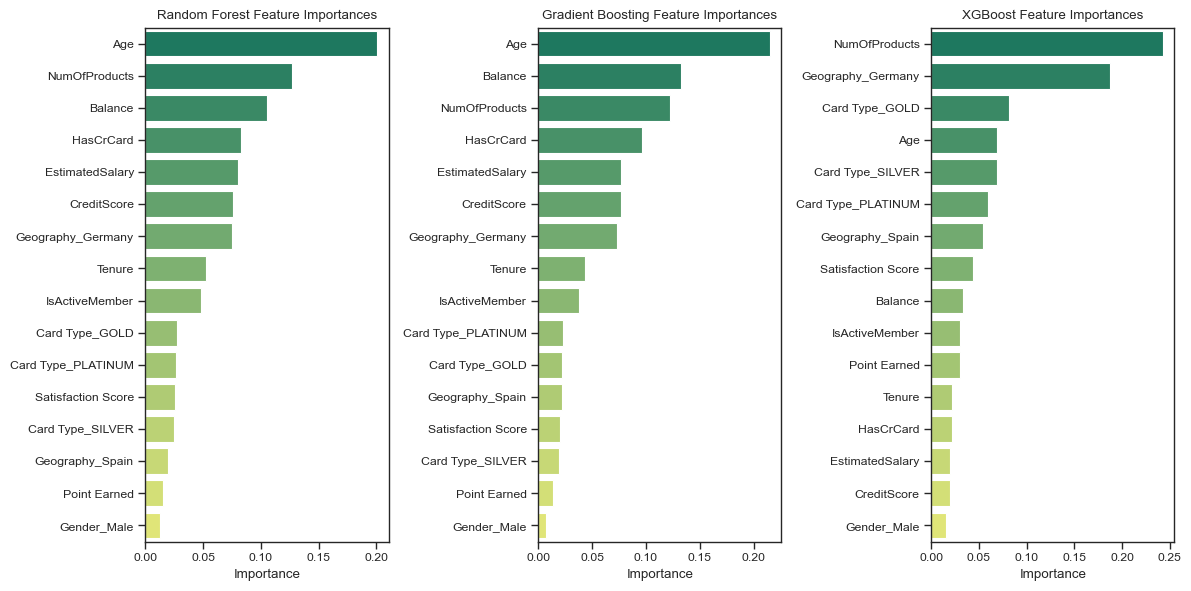

In [19]:
# Show feature importance for Random Forest, Gradient Boosting and XGBoost

# Extract feature importances
rf_feature_importances = rf_grid.best_estimator_['model'].feature_importances_
gb_feature_importances = gb_grid.best_estimator_['model'].feature_importances_
xgb_feature_importances = xgb_grid.best_estimator_['model'].feature_importances_

# Create DataFrames for feature importances
rf_feature_importances_df = pd.DataFrame(rf_feature_importances, index=all_features, columns=['Importance'])
gb_feature_importances_df = pd.DataFrame(gb_feature_importances, index=all_features, columns=['Importance'])
xgb_feature_importances_df = pd.DataFrame(xgb_feature_importances, index=all_features, columns=['Importance'])

# Sort the DataFrames by importance
rf_feature_importances_df = rf_feature_importances_df.sort_values(by='Importance', ascending=False)
gb_feature_importances_df = gb_feature_importances_df.sort_values(by='Importance', ascending=False)
xgb_feature_importances_df = xgb_feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

# Random Forest
rf_plot = sns.barplot(x='Importance', y=rf_feature_importances_df.index, data=rf_feature_importances_df, ax=ax[0], palette='summer', hue=rf_feature_importances_df.index)
rf_plot.set_title('Random Forest Feature Importances')

# Gradient Boosting
gb_plot = sns.barplot(x='Importance', y=gb_feature_importances_df.index, data=gb_feature_importances_df, ax=ax[1], palette='summer',  hue=gb_feature_importances_df.index)
gb_plot.set_title('Gradient Boosting Feature Importances')

# XGBoost
xgb_plot = sns.barplot(x='Importance', y=xgb_feature_importances_df.index, data=xgb_feature_importances_df, ax=ax[2], palette='summer',  hue=xgb_feature_importances_df.index)
xgb_plot.set_title('XGBoost Feature Importances')

# Set y label
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

plt.tight_layout()
plt.show()

Interestingly, each model has identified different features as the most important for predicting customer churn, with `Age`, `Balance` and `NumOfProducts` appearing as dominating features. This suggests that the models are capturing different aspects of the data and may have varying strengths and weaknesses.

```{index} Feature importance
```

```{admonition} Different feature importance for different models
:class: tip
When different models highlight different feature importances for the same trained dataset, it generally indicates a few key points. Different models have different ways of processing and interpreting data. For instance, linear models like logistic regression evaluate features based on their linear relationship with the target variable, while tree-based models like random forests or gradient boosting can capture non-linear relationships and interactions between features. Some models can capture interactions between features better than others. Tree-based models, for example, can show high importance for features that interact with others, while linear models might not capture these interactions effectively.

Some models might be more sensitive to certain aspects of the data structure. Models like neural networks can capture complex patterns but might also overfit to noise, whereas simpler models might miss these patterns but provide more stable feature importances. Different models employ various regularization techniques that can influence feature importance. For instance, Lasso regression penalizes the absolute size of coefficients, potentially zeroing out some features entirely, while Ridge regression penalizes the squared size, retaining more features but with smaller coefficients. Each model has its own bias-variance trade-off. A model with high bias, such as linear regression, might show feature importances that suggest a simpler relationship, while a model with low bias, like a complex neural network, might indicate a more nuanced understanding of feature importance, potentially highlighting more features as important.

To make sense of differing feature importances, consider combining feature importances from multiple models to get a more robust understanding. Use model interpretation tools like SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-agnostic Explanations) which provide model-agnostic feature importance explanations. Additionally, leverage domain expertise to understand which features are likely to be important, regardless of model output.
```

## Model evaluation on the holdout set

As a final step, let us now evaluate the best models on the holdout set to get a more accurate estimate of their performance. We will calculate various metrics such as accuracy, precision, recall, and F1 score to assess the models' performance in predicting customer churn.

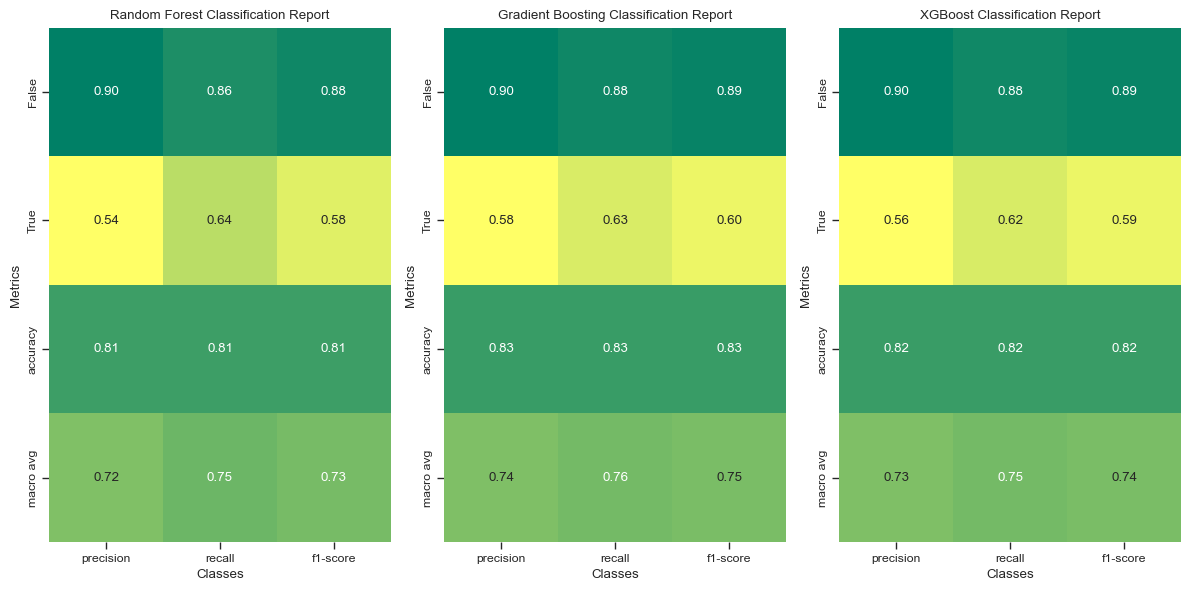

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

# Function to convert classification report to a DataFrame
def classification_report_to_df(report):
    report_dict = classification_report(y_holdout, report, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    return report_df

# Predict the target variable using the best models
rf_test_pred = rf_grid.predict(X_holdout)
gb_test_pred = gb_grid.predict(X_holdout)
xgb_test_pred = xgb_grid.predict(X_holdout)

# Create classification report dataframes
rf_report_df = classification_report_to_df(rf_test_pred)
gb_report_df = classification_report_to_df(gb_test_pred)
xgb_report_df = classification_report_to_df(xgb_test_pred)

# List of model names and their reports
models_and_reports = [
    ("Random Forest", rf_report_df),
    ("Gradient Boosting", gb_report_df),
    ("XGBoost", xgb_report_df)
]

# Plotting the classification reports on a grid
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

for (model_name, report_df), ax in zip(models_and_reports, axes.flatten()):
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="summer_r", cbar=False, ax=ax)
    ax.set_title(f'{model_name} Classification Report')
    ax.set_ylabel('Metrics')
    ax.set_xlabel('Classes')

plt.tight_layout()
plt.show()

The best performing model on the holdout set is Gradient Boosting, with an accuracy score of $\mathbf{0.83}$. This model also shows relatively balanced precision and recall values, achieving a precision of $\mathbf{0.90}$ and recall of $\mathbf{0.88}$ for the negative class, and $\mathbf{0.58}$ precision and $\mathbf{0.63}$ recall for the positive class. The F1-score, which is the harmonic mean of precision and recall, is $\mathbf{0.89}$ for the negative class and $\mathbf{0.60}$ for the positive class. 

The Random Forest and XGBoost models also perform well, each with an accuracy score of $\mathbf{0.81}$ and $\mathbf{0.82}$, respectively. However, both models exhibit slightly lower precision and recall for the positive class compared to Gradient Boosting. The Random Forest model has a precision of $\mathbf{0.54}$ and recall of $\mathbf{0.64}$ for the positive class, while XGBoost shows a precision of $\mathbf{0.56}$ and recall of $\mathbf{0.62}$ for the same class.

The overall macro average metrics (precision, recall, and F1-score) indicate that Gradient Boosting slightly outperforms the other models, providing a balanced and robust performance across different metrics. This makes Gradient Boosting the most reliable model among the three for this particular dataset, especially considering the trade-offs between precision and recall for both classes.

Let's now plot the ROC curve and calculate the AUC score for the best models, to assess their performance further.

```{index} ROC curve
```

```{admonition} ROC curve
:class: tip
The ROC (Receiver Operating Characteristic) curve is a graphical representation used to evaluate the performance of a binary classification model. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.

The True Positive Rate, also known as sensitivity or recall, is calculated as:

$$
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

where $\text{TP}$ is the number of true positives and $\text{FN}$ is the number of false negatives.

The False Positive Rate is calculated as:

$$
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
$$

where $\text{FP}$ is the number of false positives and $\text{TN}$ is the number of true negatives.

The ROC curve illustrates the trade-off between sensitivity (recall) and specificity $(1 - \text{FPR})$ as the decision threshold is varied. A model with perfect classification capability would have a point in the upper left corner of the ROC space, representing 100% sensitivity and 0% false positive rate.

In practice, the Area Under the ROC Curve (AUC) is often used as a summary metric to quantify the overall performance of the model. An AUC value of 1 indicates a perfect model, whereas an AUC value of 0.5 suggests a model with no discriminatory ability, equivalent to random guessing.

The ROC curve is particularly useful because it provides a comprehensive view of a model's performance across all threshold levels, making it easier to compare different models or to choose an optimal threshold based on the specific needs of a problem. For example, in a medical diagnosis scenario, one might prefer a threshold that minimizes false negatives to ensure no case is missed, even if it means accepting more false positives.
```

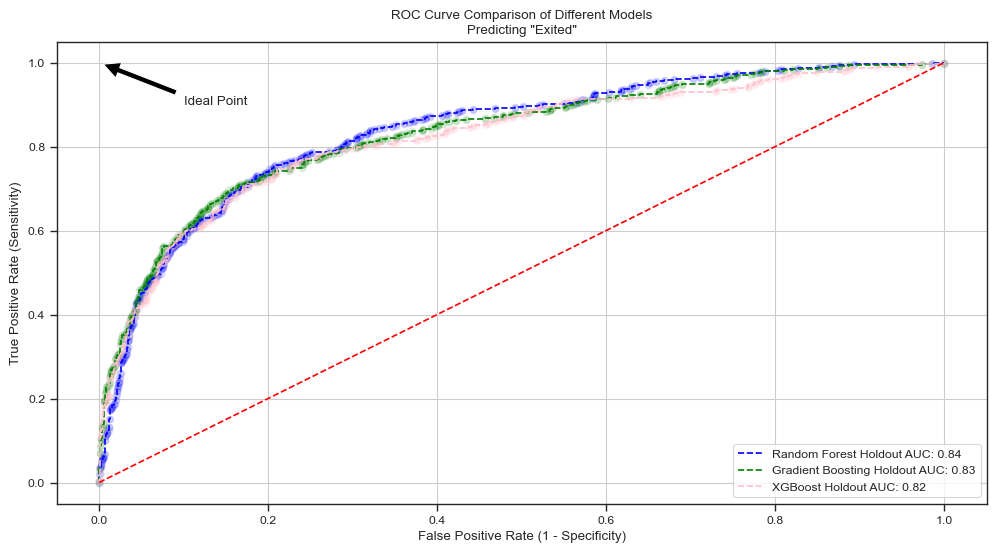

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the probabilities for each model
rf_test_probs = rf_grid.predict_proba(X_holdout)[:, 1]
gb_test_probs = gb_grid.predict_proba(X_holdout)[:, 1]
xgb_test_probs = xgb_grid.predict_proba(X_holdout)[:, 1]

# Compute the ROC curve for each model
rf_test_fpr, rf_test_tpr, _ = roc_curve(y_holdout, rf_test_probs)
gb_test_fpr, gb_test_tpr, _ = roc_curve(y_holdout, gb_test_probs)
xgb_test_fpr, xgb_test_tpr, _ = roc_curve(y_holdout, xgb_test_probs)

# Compute the ROC AUC score for each model
rf_test_auc = roc_auc_score(y_holdout, rf_test_probs)
gb_test_auc = roc_auc_score(y_holdout, gb_test_probs)
xgb_test_auc = roc_auc_score(y_holdout, xgb_test_probs)

# Plot the ROC curve for each model
plt.figure(figsize=(12, 6))

plt.plot(rf_test_fpr, rf_test_tpr, label=f"Random Forest Holdout AUC: {rf_test_auc:.2f}", color='blue', linestyle='--')
plt.plot(gb_test_fpr, gb_test_tpr, label=f"Gradient Boosting Holdout AUC: {gb_test_auc:.2f}", color='green', linestyle='--')
plt.plot(xgb_test_fpr, xgb_test_tpr, label=f"XGBoost Holdout AUC: {xgb_test_auc:.2f}", color='pink', linestyle='--')

# Plot the random chance line
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# Add scatter points for threshold markers
plt.scatter(rf_test_fpr, rf_test_tpr, alpha=0.1, color='blue')
plt.scatter(gb_test_fpr, gb_test_tpr, alpha=0.1, color='green')
plt.scatter(xgb_test_fpr, xgb_test_tpr, alpha=0.1, color='pink')

# Annotate the ideal point
plt.annotate('Ideal Point', xy=(0, 1), xytext=(0.1, 0.9),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

# Axis labels
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

# Title and grid
plt.title('ROC Curve Comparison of Different Models\nPredicting "Exited"')
plt.grid(True)

# Legend in the right bottom corner
plt.legend(loc='lower right')
plt.show()

The Random Forest model, represented by the blue dashed line, has the highest Area Under the Curve (AUC) at 0.84, indicating the best overall performance. Its curve is closer to the top-left corner, suggesting a good balance between sensitivity and specificity. Gradient Boosting, represented by the green dashed line, has an AUC of 0.83, showing strong performance, though slightly less optimal than Random Forest. The XGBoost model, represented by the pink dashed line, has an AUC of 0.82, the lowest among the three but still relatively high. The ROC curve for XGBoost is slightly below the others, indicating marginally lower performance. The “Ideal Point” on the graph at (0,1) represents perfect classification with 100% sensitivity and 0% false positives. All three models perform well, with high AUC values above 0.80, showing good discriminatory power. The Random Forest model is the best performing, followed closely by Gradient Boosting and XGBoost. The differences in performance are not substantial, indicating that all three models are robust and reliable for this classification task.

### Picking between classification reports and ROC curves

We now have two slightly different views on the model performance - classification reports hint at Gradient Boosting being the best model, while the ROC curves suggest Random Forest is the best model. This is a common situation in machine learning, where different metrics can provide slightly different perspectives on model performance. The choice between classification reports and ROC curves depends on the specific requirements of the problem and the trade-offs between different evaluation metrics.

The ROC curve is particularly useful for evaluating the performance of a binary classification model across different threshold levels. It provides a comprehensive view of the trade-offs between True Positive Rate (sensitivity) and False Positive Rate (1 - specificity), and the Area Under the Curve (AUC) gives a single scalar value summarizing the model's ability to discriminate between positive and negative classes. This makes the ROC curve ideal for comparing multiple models' performance in a holistic manner, regardless of the decision threshold.

On the other hand, a model classification report offers detailed metrics at a specific threshold, including precision, recall, F1-score, and support for each class. This report is useful for understanding the model's performance in terms of how well it predicts each class, taking into account the balance between precision and recall. It is particularly helpful when you need to focus on the performance for a particular class or understand the model's behavior in terms of specific error types (false positives vs. false negatives).

If you need to compare models broadly and understand their performance across various thresholds, the ROC curve is more advantageous. However, if you need detailed insights into how a model performs for each class and specific error metrics at a given threshold, a model classification report is more informative. Ideally, both tools should be used together to get a comprehensive understanding of a model's performance.

## Final remarks

In this experiment, we explored a classical machine learning problem: predicting customer churn. We started by loading and preprocessing the dataset, including handling missing values, encoding categorical features, and balancing the class distribution. We then performed exploratory data analysis to understand the data better, visualizing the distributions of numerical features, examining the interdependencies between features, and identifying patterns using dimensionality reduction techniques.

We selected three models - Random Forest, Gradient Boosting, and XGBoost - and evaluated their performance using cross-validation on the training set. We then tested the best models on a holdout set to get a more accurate estimate of their performance. The Random Forest model emerged as the best performer based on the ROC curve, while Gradient Boosting showed the best overall performance in the classification report. The XGBoost model also performed well, with slightly lower scores than the other two models.